# Predicting Mobile Apps Rating
## A Linear Model Project
It feels like everyone have atleast one app idea that they say would make milloins. Ironically, I don't know anybody that actually have gone through with their idea. But if they did, would the app be successful? In this project a linear model will be created to predict the rating of mobile apps. The goals of this project are:
* Make a model that successfully predicts the rating.
* Find out which variables that are important for predicting.


## Table of contents
1. [Data Exploration](#Data)
2. [Final Dataset](#Final)
3. [Modelling](#Modelling)
 01.  [Benchmark Model](#Bench)
 02.  [Final Model](#Final2)
3. [Summary](#Summary)

<a name="Data"></a>
## Data Exploration
We will start by loading the packages and the data. Thereafter, I always check the pattern of the missing data.

In [1]:
import math
import pandas as pd  
import random
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

random.seed(910)


data = pd.read_csv('Data/googleplaystore.csv')

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                Total   Percent
Rating           1474  0.135965
Current Ver         8  0.000738
Android Ver         3  0.000277
Content Rating      1  0.000092
Type                1  0.000092
Last Updated        0  0.000000
Genres              0  0.000000
Price               0  0.000000
Installs            0  0.000000
Size                0  0.000000
Reviews             0  0.000000
Category            0  0.000000
App                 0  0.000000


Here, we can see that the missing data is not that servere, around 14%, and most of it is in our dependent variable. Due to this reason, listwise deletion is used to handle the NA:s.

In [2]:
data = data.dropna()
print(data.shape)

(9360, 13)


The updated dataset have 13 variables and 9360 observations each. Before the data is split into a training- and a testing dataset, it is good to visualize the data and the patterns in it. 

Text(0.5, 1.0, 'Rating distribution')

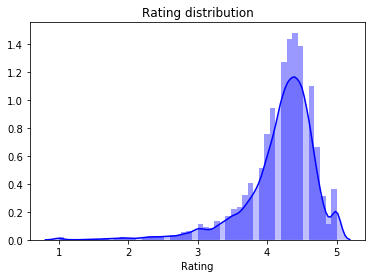

In [8]:
sns.distplot(data['Rating'], hist=True, color="b", kde_kws={"shade": True}).set_title('Rating distribution')

Our dependent variable, Rating, is between 1-5 and seems skeewed to the higher possible values.

Text(0.5, 1.0, 'Review distribution')

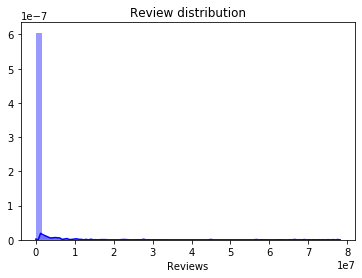

In [9]:
data['Reviews'] = data['Reviews'].apply(lambda x: int(x))
sns.distplot(data['Reviews'], hist=True, color="b", kde_kws={"shade": True}).set_title('Review distribution')

The variable "Number of Reviews" is either very low or enormous. This is not good, since it is very far from the standard normal distribution. So let's try to take the logarithm of the variable and see if it looks better. 

Text(0.5, 1.0, 'Log-Review distribution')

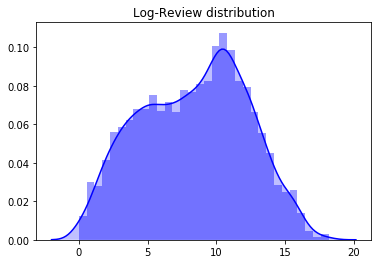

In [10]:
rew_log = np.log(np.array(data['Reviews']))
sns.distplot(rew_log, hist=True, color="b", kde_kws={"shade": True}).set_title('Log-Review distribution')

Perfect, this looks much better! I feel confident using this logged version of the variable when it is time to predict. 

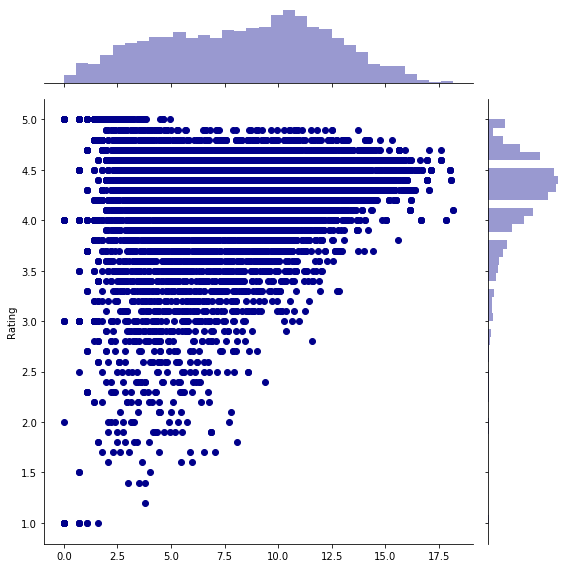

In [11]:
sns.jointplot(x=rew_log, y=data["Rating"],color = 'darkblue',size = 8)

This plot shows the relationsship between the variables "Reviews" and "The logarithm of Number of Reviews". As one can see, when the "The logarithm of Number of Reviews" goes up, the spread of the "Ratings" shortens. 

In [12]:
len(data[data.Size == 'Varies with device'])

1637

There are some observations that varies in size when the device changes. This does not give us any useful information. Therefore, they are regarded as NA:s. 

In [13]:
data['Size'].replace('Varies with device', np.nan, inplace = True ) 
data.Size = (data.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
             data.Size.str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))
data['Size'].fillna(data.groupby('Category')['Size'].transform('median'),inplace = True)

In the code chunk above the observations that varies in size when the device changes are imputated through their respective categorical median.  

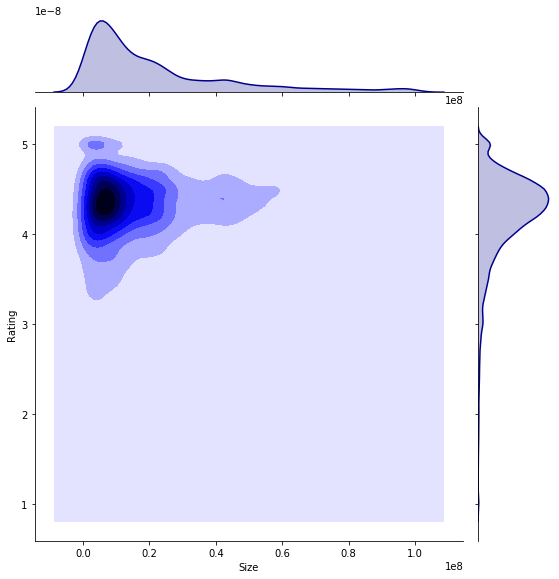

In [14]:
sns.jointplot(x="Size", y="Rating",color = 'darkblue',kind="kde", data=data, size = 8)

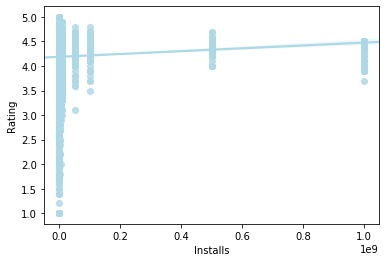

In [15]:
data.Installs = data.Installs.apply(lambda x: x.replace(',',''))
data.Installs = data.Installs.apply(lambda x: x.replace('+',''))
data.Installs = data.Installs.apply(lambda x: int(x))

sns.regplot(x="Installs", y="Rating", color = 'lightblue',data=data)

Unsurprisingly , the more popular apps have higher rating. In the next code chunk the 20 most popular words or symbols in the titles are found. Thereafter, dummies are created where 1 stands for the observations includes the word in the title and 0 for not. At last, the dummies are plotted through boxplots.

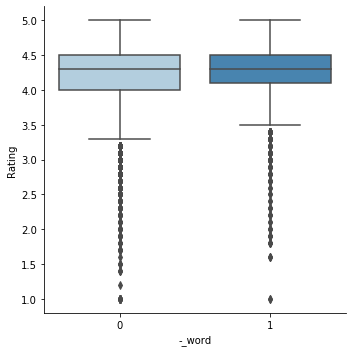

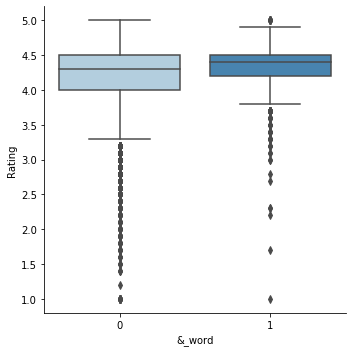

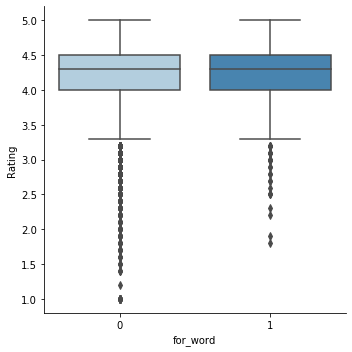

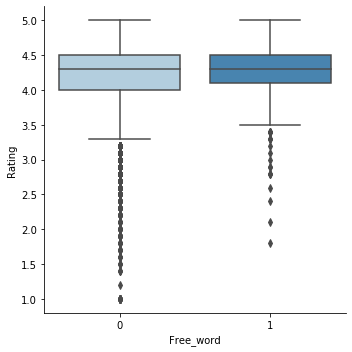

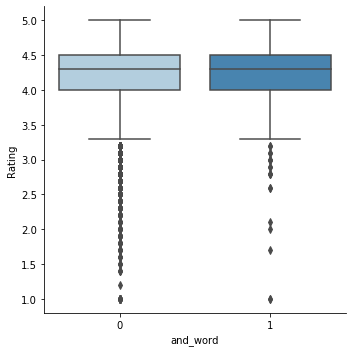

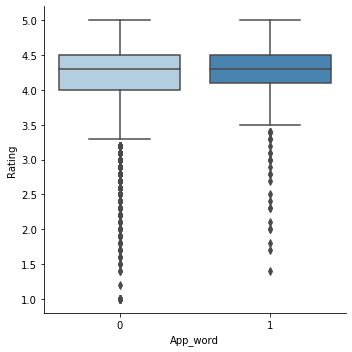

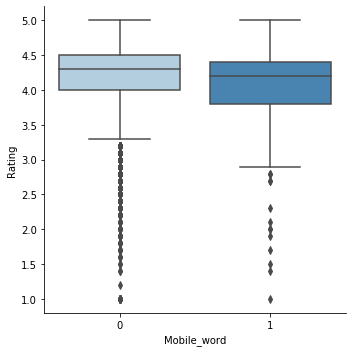

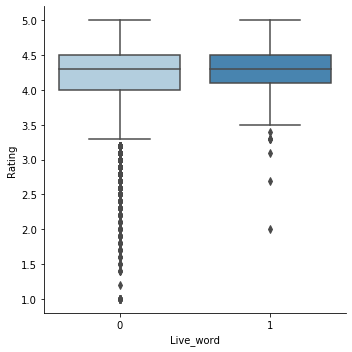

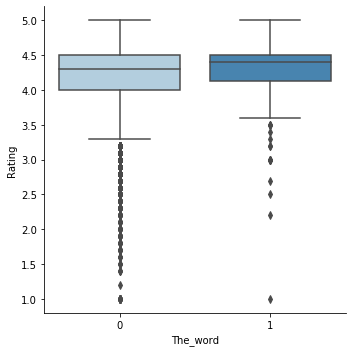

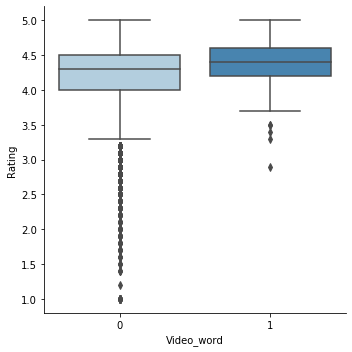

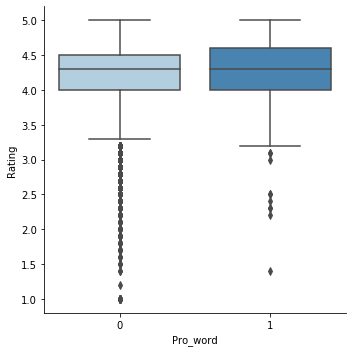

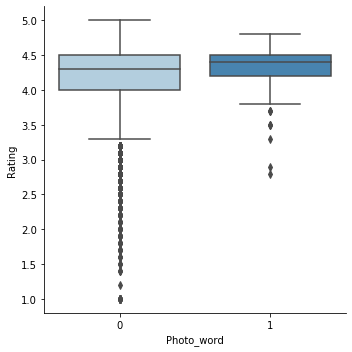

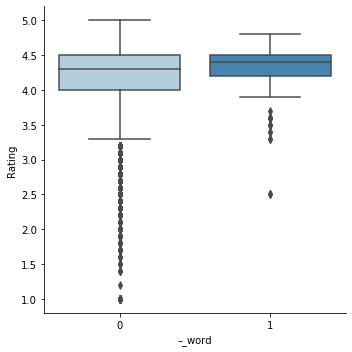

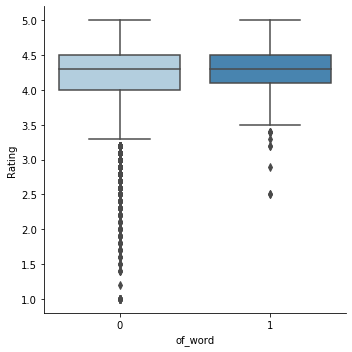

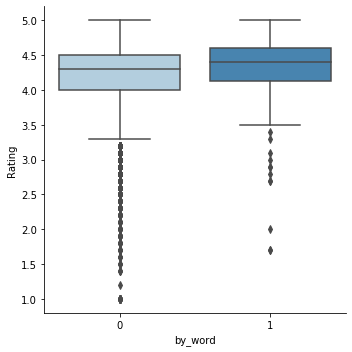

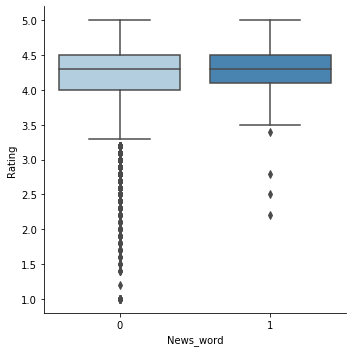

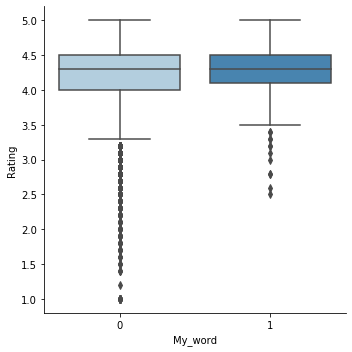

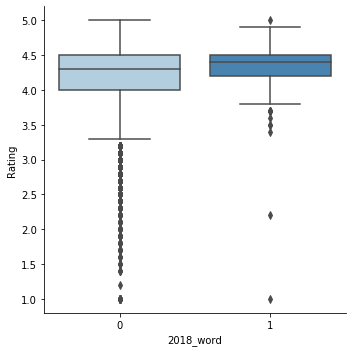

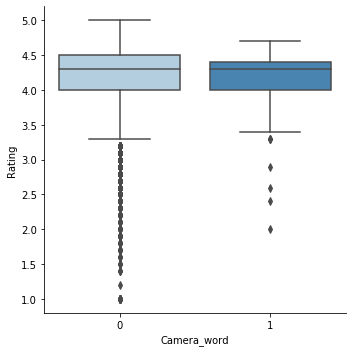

In [16]:
count_list = []
for i in data.App:
    i = i.split()
    for j in i:
        count_list.append(j)

counts = Counter(count_list)
counts.most_common(19)

c = []
for i in counts.most_common(19):
    c.append(str(i[0]))

for i in c:
    string = str(i) + "_word"
    data[string] = 0
    loc = data.columns.get_loc(string)
    app = data.columns.get_loc("App")
    for j in range(len(data)):
        if i in str(data.iloc[j,app]):
            data.iloc[j,loc] = 1


for i in data.iloc[:,13:].columns:
    sns.catplot(x=i,y="Rating",data=data, kind="box",palette = "Blues")

Two dummies stands out. First, the Video-variable for having a higher mean when it is 1. Second, the Mobile -variable for having the opposite. 

In [17]:
data.Type.value_counts() / len(data)

Free    0.93109
Paid    0.06891
Name: Type, dtype: float64

This variable is unbalanced. But, we will let it be for now. 

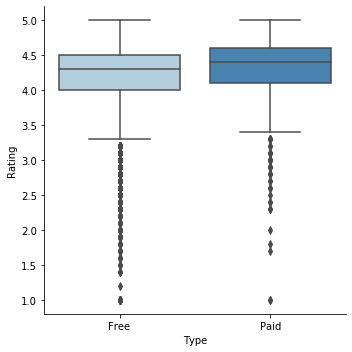

In [18]:
sns.catplot(x="Type",y="Rating",data=data, kind="box",palette = "Blues")

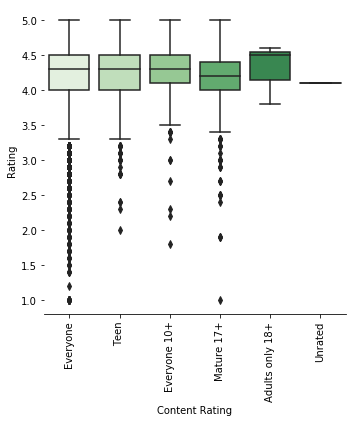

In [19]:
g = sns.catplot(x="Content Rating",y="Rating",data=data, kind="box",palette = "Greens")
g.set_xticklabels(rotation=90)
g.despine(left=True)

Mature 17+ is standing out here. Further in the project, we will create a dummy for Mature 17+. There are many categories that an app can be classified as. To make the workload easier, we will only look at the ten most popular categories. 

In [20]:
data.Genres.value_counts().head(10)

Tools            732
Entertainment    533
Education        468
Action           358
Productivity     351
Medical          350
Sports           333
Communication    328
Finance          323
Photography      317
Name: Genres, dtype: int64

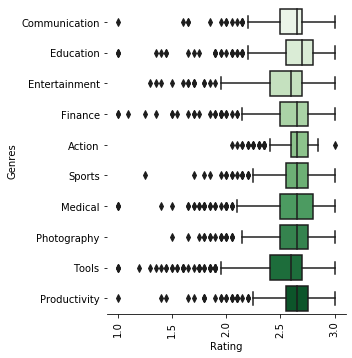

In [21]:
genres = ["Tools","Entertainment","Education","Action","Productivity","Medical","Sports","Communication","Finance","Photography"]
data2 = data.loc[data["Genres"].isin(genres)]

g = sns.catplot(y="Genres",x="Rating",data=data2, kind="box",palette = "Greens")
g.set_xticklabels(rotation=90)
g.despine(left=True)


Sports and Finance will be two dummies. For the last variable, 'Last_Updated', we will create a new one - that counts how many days the app had it last update, compared to the latest updated app. 

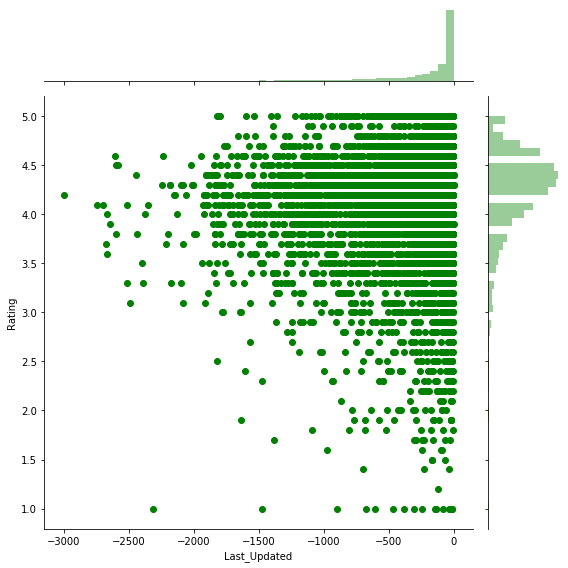

In [22]:
data['Last_Updated'] = pd.to_datetime(data['Last Updated'])
data['Last_Updated'] =  (data['Last_Updated'] -  data['Last_Updated'].max()).dt.days
g = sns.jointplot(x=data['Last_Updated'], y=data["Rating"],color = 'Green',size = 8)

<a name="Final"></a>
## Final Dataset
Now, let's create the dataset we want to use to predict the ratings. 

In [23]:
data['Mature 17+'] = pd.get_dummies(data["Content Rating"]).iloc[:,3]
data['Sport'] = pd.get_dummies(data["Genres"]).iloc[:,99]
data['Finance'] = pd.get_dummies(data["Genres"]).iloc[:,58]
data['Free'] = pd.get_dummies(data["Type"]).iloc[:,0]
data["Reviews_log"] = rew_log

clean_data = data[['Rating','Sport','Size','Installs',"Reviews_log",'Free','Mobile_word','Video_word','Mature 17+','Finance','Last_Updated']]


y = clean_data.Rating
xs = clean_data.drop('Rating', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.2)

<a name="Modelling"></a>
## Modelling
<a name="Benchmark"></a>
### Benchmark
The training and test dataset are created. To compare our final model, we need a benchmark model. Below is that model. 

In [24]:
lm_benchmark = linear_model.LinearRegression()
lm_benchmark.fit(x_train, y_train)
predictions_benchmark = lm_benchmark.predict(x_test)

mae_bench = metrics.mean_absolute_error(y_test, predictions_benchmark)
mse_bench = metrics.mean_squared_error(y_test, predictions_benchmark)
rmsea_bench = np.sqrt(metrics.mean_squared_error(y_test, predictions_benchmark))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_benchmark))  
print('Mean Squared Error:', mse_bench)  
print('Root Mean Squared Error:', rmsea_bench)

Mean Absolute Error: 0.3524030362361836
Mean Squared Error: 0.2603782619610998
Root Mean Squared Error: 0.5102727329194652


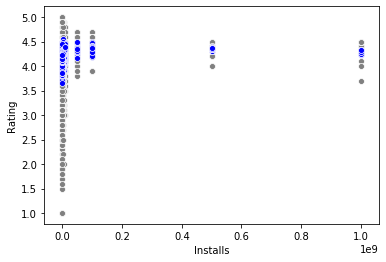

In [25]:
sns.scatterplot(x_test.Installs, y_test,  color='gray')
sns.scatterplot(x_test.Installs, predictions_benchmark, color='blue')

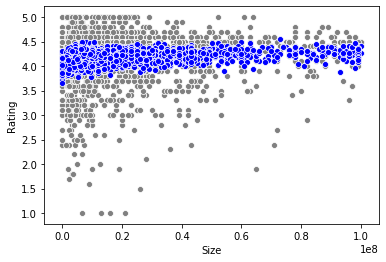

In [26]:
sns.scatterplot(x_test.Size, y_test,  color='gray')
sns.scatterplot(x_test.Size, predictions_benchmark, color='blue')

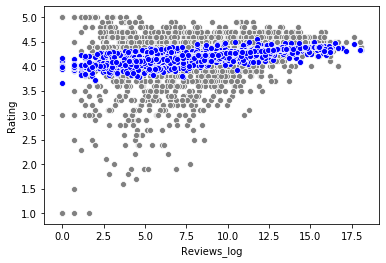

In [27]:
sns.scatterplot(x_test.Reviews_log, y_test,  color='gray')
sns.scatterplot(x_test.Reviews_log, predictions_benchmark, color='blue')

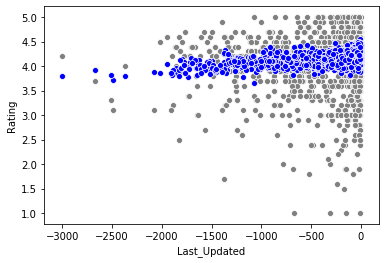

In [28]:
sns.scatterplot(x_test.Last_Updated, y_test,  color='gray')
sns.scatterplot(x_test.Last_Updated, predictions_benchmark, color='blue')

<a name="Final2"></a>
### Final model
The benchmark model is good. However, it seems to have a problem to identify the apps with lower ratings. To improve the model, we can start by looking at how the number of variables effects the R^2.

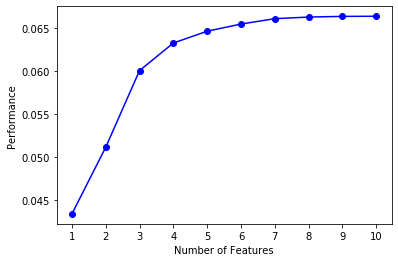

In [29]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

sfs = SFS(linear_model.LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

sfs.fit(x_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

After 7 variables, the R^2 only improves slightly. A R^2 of only 6.5% is not good and indicates that the variation in the dependent variable can be hard to capture. However, one solution to get a higher R^2 could be to include interactions, so let's do that. 

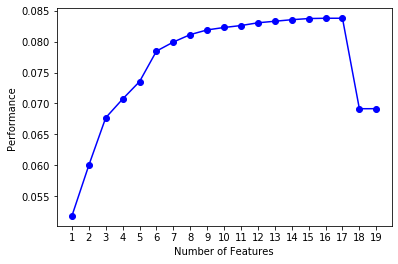

In [30]:
imp_var = ['Size','Installs','Reviews_log','Last_Updated']

for i in range(len(imp_var)):
    for j in range(i,len(imp_var)):
        word = imp_var[i] + "_" +  imp_var[j]
        x_train[word] = x_train[imp_var[i]] * x_train[imp_var[j]]
        x_test[word] = x_test[imp_var[i]] * x_test[imp_var[j]]


sfs = SFS(linear_model.LinearRegression(),
           k_features=19,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

sfs.fit(x_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

This is better! Now we have 19 variables and 17 of them are going to be used to predict the rating. The code chunk below shows the variables we are going to use. 

In [31]:
sfs_new = SFS(linear_model.LinearRegression(),
           k_features=17,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 5)
sfs_new.fit(x_train, y_train)

sfs_new.k_feature_idx_
sfs_new.k_feature_names_

('Sport',
 'Size',
 'Installs',
 'Reviews_log',
 'Free',
 'Mobile_word',
 'Video_word',
 'Mature 17+',
 'Finance',
 'Last_Updated',
 'Size_Reviews_log',
 'Size_Last_Updated',
 'Installs_Reviews_log',
 'Installs_Last_Updated',
 'Reviews_log_Reviews_log',
 'Reviews_log_Last_Updated',
 'Last_Updated_Last_Updated')

In [32]:
sfs_new = SFS(linear_model.LinearRegression(),
           k_features=1,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 5)
sfs_new.fit(x_train, y_train)

sfs_new.k_feature_idx_
sfs_new.k_feature_names_

('Reviews_log_Reviews_log',)

In [ ]:
This is the most important variable.

Let's try with a new model 

In [27]:
thechooseones = ['Sport',
 'Size',
 'Installs',
 'Reviews_log',
 'Free',
 'Mobile_word',
 'Video_word',
 'Mature 17+',
 'Finance',
 'Last_Updated',
 'Size_Reviews_log',
 'Size_Last_Updated',
 'Installs_Reviews_log',
 'Installs_Last_Updated',
 'Reviews_log_Reviews_log',
 'Reviews_log_Last_Updated',
 'Last_Updated_Last_Updated']
x_test = x_test[thechooseones]
x_train = x_train[thechooseones]


model = linear_model.LinearRegression()
model.fit(x_train, y_train)
preds = model.predict(x_test)


mae = metrics.mean_absolute_error(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
rmsea = np.sqrt(metrics.mean_squared_error(y_test, preds))
print('Mean Absolute Error:', mae)  
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmsea)


Mean Absolute Error: 0.3381119469057047
Mean Squared Error: 0.23561621079238187
Root Mean Squared Error: 0.48540314254481487


In [28]:
print(mae - mae_bench)
print(mse - mse_bench)
print(rmsea - rmsea_bench)

-0.0007167293664471219
-0.003009087501957358
-0.0030897420444483403


This model perform slightly better. But due to the low R^2, I think that we will settle us down with this model for now.

In [29]:
coefficients = pd.concat([pd.DataFrame(x_test.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
print("Intercept: ",model.intercept_)
print(coefficients)

Intercept:  4.461822819900423
                            0             0
0                       Sport  1.071296e-02
1                        Size -1.894181e-09
2                    Installs -6.423399e-10
3                 Reviews_log -5.266128e-02
4                        Free -1.730735e-01
5                 Mobile_word -1.588689e-01
6                  Video_word  1.177296e-01
7                  Mature 17+ -1.203399e-01
8                     Finance  3.133079e-03
9                Last_Updated  3.800360e-04
10           Size_Reviews_log  1.378599e-10
11          Size_Last_Updated -2.519119e-12
12       Installs_Reviews_log  1.152280e-11
13      Installs_Last_Updated  5.728949e-12
14    Reviews_log_Reviews_log  4.756994e-03
15   Reviews_log_Last_Updated -1.269595e-05
16  Last_Updated_Last_Updated  9.705829e-08


<a name="Summary"></a>
## Summary

We succeed with the half of the goals by creating a model that predicts the popularity fairly well. The model has a MSE of 0.34 when predicting the ratings that span from 1 to 5. Unfortunally, the R^2 of the model is only around 0.09. This can only be seen as a faluire. The bad R^2 is probably due to the dependent variable being very hard to predict. However, would we choose one variable that explains the variation of our dependent variable, then it would be Reviews_log^2. 

If one would be intresting in doing a similar project - I would recommend to try to predict the ratings through ML instead of a linear model.  

### Thanks for reading! 